In [1]:
import matplotlib.pyplot as plt
import torch
from models_dif import SoftmaxWeight, LocationScaleFlow, DIFDensityEstimator

tensor(0.0942)
number of samples = 60000
tensor([3.1972e-03, 3.8586e-03, 2.8623e-03, 5.0513e-05, 3.2003e-03, 5.0001e-04,
        2.2858e-03, 3.7022e-03, 3.0302e-03, 3.6327e-03, 2.7909e-03, 2.1474e-03,
        3.3343e-03, 1.1930e-03, 3.2053e-03, 4.0668e-04, 1.0651e-03, 1.1124e-04,
        2.9299e-03, 6.9026e-04, 1.8230e-03, 3.8402e-03, 2.4997e-03, 1.8137e-03,
        1.7212e-03, 2.0314e-03, 2.4504e-03, 1.1550e-03, 1.4260e-03, 2.1283e-03,
        1.7552e-03, 9.2713e-04, 1.4443e-03, 1.8400e-03, 3.8472e-03, 8.1574e-05,
        3.6368e-03, 2.4701e-03, 3.8315e-03, 3.7169e-03, 3.2193e-03, 3.3188e-03,
        1.2827e-03, 2.3775e-03, 2.4324e-03, 2.1070e-03, 1.9327e-03, 2.9816e-03,
        1.3883e-04, 3.6135e-03, 1.2321e-03, 3.1508e-03, 3.1973e-04, 3.4623e-03,
        4.3329e-04, 1.7818e-03, 2.4053e-03, 3.5908e-03, 3.5316e-03, 5.4132e-04,
        2.0624e-03, 3.0558e-03, 2.7510e-03, 2.0032e-03, 2.4676e-03, 1.0724e-03,
        3.3830e-03, 5.8862e-04, 1.6980e-03, 8.8172e-04, 2.8299e-03, 1.9552e-03,

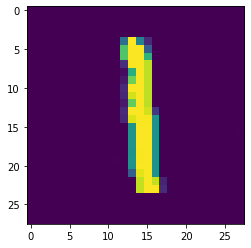

In [10]:
###MNIST###

import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
images = mnist_trainset.data.flatten(start_dim=1)
targets = mnist_trainset.targets

digit = 'all'
if digit != 'all':
    extracted = images[targets == digit].float()
else: 
    extracted = images.float()
target_samples = (extracted + torch.rand(extracted.shape))/256
print(torch.var(target_samples))

num_samples  = target_samples.shape[0]
print('number of samples = ' + str(num_samples))
p = target_samples.shape[-1]
plt.imshow(target_samples[torch.randint(low = 0, high = num_samples, size = [1])].reshape(28,28))

train_set, test_set = target_samples[:4000], target_samples[4000:]
print(train_set[0])

In [3]:
K = 35
dif = DIFDensityEstimator(target_samples, K)
dif.w = SoftmaxWeight(K,p, [256,256,256,256])
dif.train(200, 5000)

  0%|                                                                                                                                                             | 0/200 [02:16<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
dif.train(2000, 5000)

In [ ]:
### Visualize training ###
model_to_visualize = dif

import numpy as np
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

loss_values = dif.loss_values
best_loss = min(loss_values)
best_iteration = loss_values.index(best_loss)
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(111)
Y1, Y2 = best_loss - (max(loss_values) -best_loss) / 2, max(loss_values) + (max(loss_values) - best_loss) / 4
ax.set_ylim(Y1, Y2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(loss_values, label='Loss values during training', color='black')
ax.scatter([best_iteration], [best_loss], color='black', marker='d')
ax.axvline(x=best_iteration, ymax=(best_loss -best_loss + (max(loss_values) - best_loss) / 2) / (
        max(loss_values) + (max(loss_values) - best_loss) / 4 - best_loss + (
        max(loss_values) - best_loss) / 2), color='black', linestyle='--')
ax.text(0, best_loss - (max(loss_values) - best_loss) / 8,
        'best iteration = ' + str(best_iteration) + '\nbest loss = ' + str(np.round(best_loss, 5)),
        verticalalignment='top', horizontalalignment='left', fontsize=12)
if len(loss_values) > 30:
    x1, x2 = best_iteration - int(len(loss_values) / 15), min(best_iteration + int(len(loss_values) / 15),
                                                              len(loss_values) - 1)
    k = len(loss_values) / (2.5 * (x2 - x1 + 1))
    offset = (Y2 - Y1) / (6 * k)
    y1, y2 = best_loss - offset, best_loss + offset
    axins = zoomed_inset_axes(ax, k, loc='upper right')
    axins.axvline(x=best_iteration, ymax=(best_loss - y1) / (y2 - y1), color='black', linestyle='--')
    axins.scatter([best_iteration], [best_loss], color='black', marker='d')
    axins.xaxis.set_major_locator(MaxNLocator(integer=True))
    axins.plot(loss_values, color='black')
    axins.set_xlim(x1 - .5, x2 + .5)
    axins.set_ylim(y1, y2)
    mark_inset(ax, axins, loc1=3, loc2=4)

In [ ]:
with torch.no_grad():
    for _ in range(50):
        plt.figure()
        sample = dif.sample_model(1)
        plt.imshow(sample[0].reshape(28,28))